### Import the required packages

In [1]:
import requests
import sys
import json
import urllib2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Define required functions

In [2]:
def CheckResponse(r):
    status=str(r.status_code)
    if status == "200":
        #print "Finished"
        sys.stdout.flush()
    elif status == "201":
        sys.stdout.flush()
    else:
        print r, r.status_code
        sys.stdout.flush()
        
def checkCytoscapeVersion(host="localhost",port=1234):
    URL="http://"+str(host)+":"+str(port)+"/v1/version/"
    r = requests.get(url = URL)
    r=json.loads(r.content)
    for k in r.keys():
        print k, r[k]
        
def cytoscape(namespace,command="",PARAMS={},host="localhost",port=1234,method="POST",verbose=False):
    """
    General function for interacting with Cytoscape API.
    
    :param namespace: namespace where the request should be executed. eg. "string"
    :param commnand: command to execute. eg. "protein query"
    :param PARAM: a dictionary with the parameters. Check your swagger normaly running on
    http://localhost:1234/v1/swaggerUI/swagger-ui/index.html?url=http://localhost:1234/v1/commands/swagger.json
    :param method: type of http call, ie. "POST" or "GET" or "HELP".
    
    :returns: For "POST" the data in the content's response. For "GET" None. 
    
    eg.

    cytoscape("G","string","pubmed query",{"pubmed":"p53 p21","limit":"50"})


    """     

    if (method == "GET") or (method == "G"):
        P=[]
        for p in PARAMS.keys():
            v=str(PARAMS[p])
            v=v.replace(" ","%20")  
            P.append(str(p)+"="+str(PARAMS[p]))
        P="&".join(P)
        URL="http://"+str(host)+":"+str(port)+"/v1/commands/"+str(namespace)+"/"+str(command)+"?"+P
        if verbose:
            print "'"+URL+"'"
            sys.stdout.flush()
        r = requests.get(url = URL)
        CheckResponse(r)
        res=None
    
    elif (method == "POST") or (method == "P"):
        URL="http://"+str(host)+":"+str(port)+"/v1/commands/"+str(namespace)+"/"+str(command)
        r = requests.post(url = URL, json = PARAMS)
        CheckResponse(r)
        res=r.content
        if verbose:
            print res
        res=json.loads(res)
        res=res["data"]
        
    elif (method=="HTML") or (method == "H") or (method=="HELP"):
        P=[]
        for p in PARAMS.keys():
            v=str(PARAMS[p])
            v=v.replace(" ","%20")  
            P.append(str(p)+"="+str(PARAMS[p]))
        P="&".join(P)
        URL="http://"+str(host)+":"+str(port)+"/v1/commands/"+str(namespace)+"/"+str(command)+"?"+P
        if verbose:
            print "'"+URL+"'"
            sys.stdout.flush()
        response = urllib2.urlopen(URL)
        res = response.read()
        print res
        sys.stdout.flush()
    
    return res

#def HTML()

def getTableColumns(table, columns, namespace = "default", network = "current", host="localhost",port=1234,verbose=False):
    if type(network) != int:
        network=cytoscape("network", "get attribute",\
                      {"network":network,\
                       "namespace":namespace,\
                       "columnList":"SUID"})
        network=network[0]["SUID"]

    
    df=pd.DataFrame()
    def target(column):
        URL="http://"+str(host)+":"+str(port)+"/v1/networks/"+str(network)+"/tables/"+namespace+table+"/columns/"+column  
        if verbose:
            print "'"+URL+"'"
            sys.stdout.flush()
        response = urllib2.urlopen(URL)
        response = response.read()
        colA=json.loads(response)

        col=pd.DataFrame()    
        colHeader=colA["name"]
        colValues=colA["values"]
        col[colHeader]=colValues
        return col
    
    ncols=["name"]
    for c in columns:
        ncols.append(c.replace(" ","%20") )
    for c in ncols:
        col=target(c)
        df=pd.concat([df,col],axis=1)
        
    df.index=df["name"].tolist()
    df=df.drop(["name"],axis=1)
    
    return df

def loadTableData(df, df_key='index',table="node", \
                   table_key_column = "name",
                   network="current",\
                   namespace="default",\
                   host="localhost",port=1234,verbose=False):
    
    if type(network) != int:
        networkID=cytoscape("network", "get attribute",\
                      {"network":network,\
                       "namespace":namespace,\
                       "columnList":"SUID"})
        networkname=cytoscape("network", "get attribute",\
                      {"network":network,\
                       "namespace":namespace,\
                       "columnList":"name"})
        
        network=networkID[0]["SUID"]
        networkname=networkname[0]["name"]
        
    tmp=df.copy()
    if df_key!="index":
        tmp.index=tmp[df_key].tolist()
        tmp=tmp.drop([df_key],axis=1)
            
    tablen=networkname+" default node"
    
    data=[]
    
    for c in tmp.columns.tolist():
        for r in tmp.index.tolist():
            cell={}
            cell[str(table_key_column)]=str(r)
            cell[str(c)]=str(tmp.ix[r,c])
            data.append(cell)
    
    
    upload={"key":table_key_column,"dataKey":table_key_column,\
            "data":data}
    
    
    URL="http://"+str(host)+":"+str(port)+"/v1/networks/"+str(network)+"/tables/"+namespace+table  
    if verbose:
        print "'"+URL+"'"
        sys.stdout.flush()
    r = requests.put(url = URL, json = upload)
    if verbose:
        print r
    CheckResponse(r)
    res=r.content
    return res

def visual_defaults(defaults_dic):
    defaults=[]
    for d in defaults_dic.keys():
        dic={}
        dic["visualProperty"]=d
        dic["value"]=defaults_dic[d]
        defaults.append(dic)
    return defaults

def create_styles(title,defaults,mappings,host="localhost",port=1234,method="POST"):
    URL="http://"+str(host)+":"+str(port)+"/v1/styles"
    PARAMS={"title":title,\
           "defaults":defaults,\
           "mappings":mappings}
    r = requests.post(url = URL, json = PARAMS)
    CheckResponse(r)

### Setup Cytoscape
* Launch Cytoscape on your local machine. If you haven't already installed Cytoscape, then download the latest version from http://cytoscape.org.
* Install the STRING app, if you haven't already: http://apps.cytoscape.org/apps/stringapp
* Leave Cytoscape running in the background during the remainder of the tutorial.
* Check cytoscape connection.

In [3]:
checkCytoscapeVersion()

cytoscapeVersion 3.6.0
apiVersion v1


cleanse the palette before importing new networks and styles

In [4]:
response=cytoscape("vizmap", "apply",{"styles":"default"})

################################################
# Step 1: Getting Disease Networks
################################################

Use Cytoscape to query the STRING database for networks of genes associated with breast cancer and ovarian cancer.

**If the STRING app is not installed, no error is reported, but your network  will be empty**

### Query STRING database by disease to generate networks

#### Breast cancer

In [5]:
response=cytoscape("string", "disease query",\
                  {"disease":"breast cancer",\
                   "cutoff":"0.9",\
                   "species":"Homo sapiens",\
                   "limit":"150"})

Here we are using Cytoscape's command line syntax, converting it to a CyREST url, and then making a PUT request. 

#### Ovarian cancer

In [6]:
response=cytoscape("string", "disease query",\
                  {"disease":"ovarian cancer",\
                   "cutoff":"0.9",\
                   "species":"Homo sapiens",\
                   "limit":"150"})

################################################
# Step 2: Interacting with Cytoscape 
################################################

Now that we've got a couple networks into Cytoscape, let's see what we can go with them from R...

### Get list of networks 

In [7]:
response=cytoscape("network", "list")
print response

[25138, 26232]


### Layout network

In [8]:
response=cytoscape("layout", "circular")

#### List of layout algorithms available

In [9]:
response=cytoscape("layout",method="HELP")

Available commands for 'layout':
  apply preferred
  attribute-circle
  attributes-layout
  circular
  copycat
  cose
  degree-circle
  force-directed
  force-directed-cl
  fruchterman-rheingold
  genemania-force-directed
  get preferred
  grid
  hierarchical
  isom
  kamada-kawai
  set preferred
  stacked-node-layout



#### Layout with parameters!

In [10]:
response=cytoscape("layout", "force-directed",\
                  {"defaultSpringCoefficient":".000004",\
                   "defaultSpringLength":"5"})

In [11]:
response=cytoscape("layout","force-directed",method="HELP")

Available arguments for 'layout force-directed':
  defaultEdgeWeight
  defaultNodeMass
  defaultSpringCoefficient
  defaultSpringLength
  EdgeAttribute
  isDeterministic
  maxWeightCutoff
  minWeightCutoff
  network
  NodeAttribute
  nodeList
  numIterations
  singlePartition
  Type



These *command* calls will allow you to interrogate the layouts and parameters available in your active Cytoscape session. This includes any layouts added by apps you've installed!

### Get table data from network
Now, let's look at the tablular data associated with our STRING networks...

In [12]:
response=cytoscape("node","list attributes",\
                   {"network":"current",\
                   "namespace":"default"} )
print response

[u'SUID', u'shared name', u'name', u'selected', u'canonical name', u'database identifier', u'description', u'@id', u'namespace', u'node type', u'query term', u'sequence', u'species', u'STRING style', u'enhancedLabel Passthrough', u'canonical', u'compartment chloroplast', u'compartment cytoskeleton', u'compartment cytosol', u'compartment endoplasmic reticulum', u'compartment endosome', u'compartment extracellular', u'compartment golgi apparatus', u'compartment lysosome', u'compartment mitochondrion', u'compartment nucleus', u'compartment peroxisome', u'compartment plasma membrane', u'compartment vacuole', u'image', u'target development level', u'target family', u'tissue adrenal gland', u'tissue blood', u'tissue bone', u'tissue bone marrow', u'tissue eye', u'tissue gall bladder', u'tissue heart', u'tissue intestine', u'tissue kidney', u'tissue liver', u'tissue lung', u'tissue lymph node', u'tissue muscle', u'tissue nervous system', u'tissue pancreas', u'tissue saliva', u'tissue skin', u'

One of the great things about the STRING database is all the node and edge attriubtes they provide. Let's pull some of it into R to play with...

#### Retrieve disease scores 
We can retrieve any set of columns from Cytoscape and store them as an R data frame.

In [13]:
disease_score_table=getTableColumns('node',['disease score'])
disease_score_table



,disease score
CDK12,1.637925
CTAG1B,1.708656
NBN,5.000000
PAX8,1.891827
STK11,5.000000
SNAI1,2.025321
EIF3A,1.745645
C10orf2,1.790888
MLH1,5.000000
DAB2,1.668835


#### Plot distribution and pick threshold
Now you can use python like you normally would explore the data.

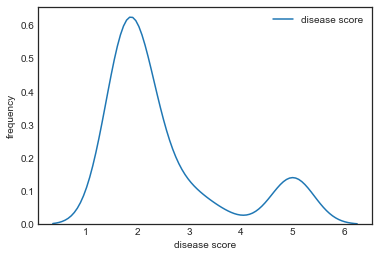

In [14]:
sns.set_style("white")
sns.kdeplot( disease_score_table["disease score"] )
plt.xlabel("disease score")
plt.ylabel("frequency")

### Generate subnetworks
In order to reflect your exploration back onto the network, let's generate subnetworks...

...from top quartile of 'disease score'

In [15]:
top_quart=disease_score_table[["disease score"]].quantile(0.75)[0]
top_nodes=disease_score_table[disease_score_table["disease score"]>top_quart].index.tolist()
top_nodes

[u'NBN',
 u'STK11',
 u'MLH1',
 u'MSH6',
 u'ANKLE1',
 u'AKT1',
 u'PALB2',
 u'ARID1A',
 u'MSH2',
 u'RAD51C',
 u'HOXD3',
 u'MLLT10',
 u'ERBB2',
 u'BRIP1',
 u'HNF1B',
 u'BNC2',
 u'PARK2',
 u'CTNNB1',
 u'MUC16',
 u'BRCA1',
 u'BABAM1',
 u'PARP1',
 u'OPCML',
 u'KRAS',
 u'FOXL2',
 u'PIK3CA',
 u'CHMP4C',
 u'TIPARP',
 u'TP53',
 u'PTEN',
 u'RAD50',
 u'CDH1',
 u'BRCA2',
 u'RAD51D',
 u'PMS2',
 u'CHEK2',
 u'DGCR14',
 u'BARD1']

In [16]:
values="name:"+",".join(top_nodes)
response=cytoscape("network","create",
                   {"source":"current",\
                    "excludeEdges":"false",\
                    "nodeList":values})
response=cytoscape("network","rename",\
                   {"name":'top disease quartile'})

...of connected nodes only

In [17]:
response=cytoscape("network","create",
                   {"source":"current",\
                    "edgeList":"all",\
                    "nodeList":"selected"})

...from first neighbors of top 3 genes, using the network connectivity together with the data to direct discovery.

In [18]:
response=cytoscape("network","set current",
                   {"network":"String Network - ovarian cancer"})

In [19]:
top_nodes=disease_score_table.sort_values(by=["disease score"],\
                                         ascending=False)
top_nodes=top_nodes.index.tolist()[:3]
print top_nodes

[u'BRCA1', u'AKT1', u'OPCML']


In [20]:
response=cytoscape("network","select",
                   {"nodeList":"name:"+",".join(top_nodes)})

In [21]:
response=cytoscape("network","select",
                   {"firstNeighbors":"",\
                    "direction":"any",\
                    "network":"current"})

In [22]:
response=cytoscape("network","create",
                   {"source":"current",\
                    "nodeList":"selected"})

In [23]:
response=cytoscape("network","rename",\
                   {"name":'top disease neighbors'})

...from diffusion algorithm starting with top 3 genes, using the network connectivity in a more subtle way than just first-degree neighbors.

In [24]:
response=cytoscape("network","set current",
                   {"network":"String Network - ovarian cancer"})
response=cytoscape("network","select",
                   {"nodeList":"name:"+",".join(top_nodes)})
response=cytoscape("diffusion","diffuse")
response=cytoscape("network","create",
                   {"source":"current",\
                    "nodeList":"selected"})
response=cytoscape("layout", "force-directed")
response=cytoscape("network","rename",\
                   {"name":'top disease diffusion'})

################################################
# Step 3: Visualizing data on networks
################################################

### Load datasets
Downloaded TCGA data from https://portal.gdc.cancer.gov/ and preprocessed as R objects. Also available via each TCGA publication, e.g.:
 
* Breast: https://tcga-data.nci.nih.gov/docs/publications/brca_2012/
* Ovarian: https://tcga-data.nci.nih.gov/docs/publications/ov_2011/

In [25]:
brc_expr=pd.read_table("/Users/jboucas/brc.exp.tsv")
brc_mut=pd.read_table("/Users/jboucas/brc.mut.tsv")

### Breast Cancer Datset
These datasets are similar to the data frames you normarlly encounter in R. For diversity, one using row.names to store corresponding gene names and the other uses the first column. Both are easy to import into Cytoscape.

In [26]:
brc_expr.head()

,expr.mean
ELMO2,-0.000167
CREB3L1,-0.005408
RPS11,0.018381
PNMA1,-0.065037
MMP2,-0.074444


In [27]:
brc_mut.head()

,Hugo_Symbol,mut_count,missense_mut_count
13,A1CF,2,2
14,A2BP1,3,3
15,A2M,3,2
16,A2ML1,4,4
17,A4GALT,1,0


Let's return to the Breast Cancer network...

In [28]:
response=cytoscape("network","set current",
                   {"network":"String Network - breast cancer"})
response=cytoscape("layout", "force-directed",\
                   {"defaultSpringCoefficient":".000004",\
                   "defaultSpringLength":"5"})

...and use the helper function from r2cytoscape called *loadTableData*


In [29]:
response=loadTableData(brc_expr)
response=loadTableData(brc_mut,df_key='Hugo_Symbol')

#### Visual styles
Let's create a new style to visualize our imported data
...starting with the basics, we will specify a few defaults and obvious mappings in a custom style all our own.

In [30]:
style_name = "dataStyle"

defaults_dic={"NODE_SHAPE":"ellipse",\
               "NODE_SIZE":"60",\
               "NODE_FILL_COLOR":"#AAAAAA",\
               "EDGE_TRANSPARENCY":"120"}
defaults=visual_defaults(defaults_dic)

mappings_dic_A={"mappingType":"passthrough",\
                "mappingColumn":"name",\
                "mappingColumnType":"String",\
                "visualProperty":"NODE_LABEL"}
mappings=[mappings_dic_A]

create_styles("dataStyle",defaults,mappings)

In [31]:
response=cytoscape("vizmap", "apply", {"styles":"dataStyle"})

Now let's update the style with a mapping for mean expression. The first step is to grab the column data from Cytoscape and pull out the min and max to define our data mapping range of values.

In [32]:
brc_expr_network = getTableColumns('node',['expr.mean'])

In [33]:
min_brc_expr = min(brc_expr_network.dropna()['expr.mean'].tolist())
max_brc_expr = max(brc_expr_network.dropna()['expr.mean'].tolist())
#data.values = c(min.brc.expr,0,max.brc.expr)
print min_brc_expr, max_brc_expr

-0.00182769652651 0.512930822669


In [34]:
#https://matplotlib.org/users/colormaps.html